In [2]:
import os
import pandas as pd

In [3]:
data = pd.read_csv(
    './data/txt2csv_train/changmin_1.csv'
)

In [4]:
data.head(10)

,Date,User,Message
0,2024-05-10 14:35:42,이창민,"이창민 invited 휴먼22 신은빈, 휴먼20 유민균, 컴과21 이예니, 지능22..."
1,2024-05-10 14:35:42,이창민,안녕하세요!
2,2024-05-10 14:35:47,이창민,부랴부랴 만들었네요
3,2024-05-10 14:35:54,지능22 이소정,안녕하세요!
4,2024-05-10 14:36:13,이창민,팀장이자 휴먼지능정보공학전공 20학번인 이창민입니다!
5,2024-05-10 14:36:17,이창민,잘 부탁드립니다~
6,2024-05-10 14:36:42,이창민,저희 우선 개인과제를 우선적으로 진행하고… 차주 주말 정도에 1차 회의 진행하고자하...
7,2024-05-10 14:36:48,이창민,토요일로 생각 중입니다
8,2024-05-10 14:36:55,휴먼20 유민균,좋은 것 같습니다
9,2024-05-10 14:37:00,지능22 이소정,좋아요!


In [5]:
# 발언 횟수 계산
message_counts = data["User"].value_counts(normalize=False)
message_ratio = data["User"].value_counts(normalize=True)

# 사진 전송 횟수 (예: 메시지에 '사진' 또는 'image'가 포함된 경우)
image_counts = data["Message"].str.contains("사진|image", case=False, na=False).groupby(data["User"]).sum()

# 질문 수 (예: 메시지에 '?' 포함된 경우)
question_counts = data["Message"].str.contains(r"\\?", na=False).groupby(data["User"]).sum()

# 파일 전송 횟수 (예: 메시지에 '파일' 또는 'file' 포함된 경우)
file_counts = data["Message"].str.contains("파일|file", case=False, na=False).groupby(data["User"]).sum()

# 링크 전송 횟수 (예: 메시지에 'http' 포함된 경우)
link_counts = data["Message"].str.contains(r"http", na=False).groupby(data["User"]).sum()

# 사람 언급 횟수 (예: '@' 또는 특정 이름이 포함된 경우)
mention_counts = data["Message"].str.contains(r"휴먼|지능|컴과|@", na=False).groupby(data["User"]).sum()

# 말풍선당 길이 평균 (메시지 길이 계산 후 평균)
avg_message_length = data["Message"].str.len().groupby(data["User"]).mean()

# 결과 데이터프레임 생성
data_engineer = pd.DataFrame({
    "발언 횟수": message_counts,
    "발언 횟수 비율": message_ratio,
    "사진 전송 횟수": image_counts,
    "질문 수": question_counts,
    "파일 전송 횟수": file_counts,
    "링크 전송 횟수": link_counts,
    "사람 언급": mention_counts,
    "말풍선당 길이 평균": avg_message_length
}).fillna(0)

data_engineer.head(10)

,발언 횟수,발언 횟수 비율,사진 전송 횟수,질문 수,파일 전송 횟수,링크 전송 횟수,사람 언급,말풍선당 길이 평균
User,,,,,,,,
로봇26 황유성,79,0.061383,1,79,5,1,1,17.202532
이창민,655,0.508936,3,655,12,7,11,29.661069
지능22 이소정,203,0.157731,1,203,7,3,2,21.605911
컴과21 이예니,113,0.087801,0,113,14,4,0,40.141593
휴먼20 유민균,87,0.067599,1,87,8,6,1,23.034483
휴먼22 신은빈,150,0.116550,0,150,15,7,4,53.086667


In [6]:
# 날짜만 추출
data['Date'] = pd.to_datetime(data['Date']).dt.date

# 발언 횟수 계산 (날짜별 사용자별)
message_counts = data.groupby(['Date', 'User']).size()

# 사진, 파일, 링크 횟수를 각각 계산
data['is_image'] = data['Message'].str.contains("사진|image", case=False, na=False)
data['is_file'] = data['Message'].str.contains("파일|file", case=False, na=False)
data['is_link'] = data['Message'].str.contains(r"http", na=False)

# 사진, 파일, 링크 횟수를 합쳐서 하나의 피처로 묶기
combined_feature_counts = (data['is_image'] | data['is_file'] | data['is_link']).groupby([data['Date'], data['User']]).sum()

# 질문 수
question_counts = data[data['Message'].str.contains(r"\?", na=False)].groupby(['Date', 'User']).size().astype(int)

# 사람 언급 횟수
mention_counts = data[data['Message'].str.contains(r"@", na=False)].groupby(['Date', 'User']).size()

# 말풍선당 길이 평균
avg_message_length = data.groupby(['Date', 'User'])['Message'].apply(lambda x: x.str.len().mean())

# 발언 횟수 비율 계산 (날짜별 사용자별 발언 횟수 / 날짜별 전체 발언 횟수)
message_ratio = (data.groupby(['Date', 'User']).size() / data.groupby('Date').size()).reset_index(name='발언 횟수 비율')

# 하루 단위 데이터프레임 생성
daily_data = pd.DataFrame({
    "발언 횟수": message_counts,
    "발언 횟수 비율": message_ratio.set_index(['Date', 'User'])['발언 횟수 비율'],
    "사진/파일/링크 전송 합계": combined_feature_counts,
    "질문 수": question_counts,
    "사람 언급": mention_counts,
    "말풍선당 길이 평균": avg_message_length
}).fillna(0).reset_index()

# 정수 변환할 컬럼 지정
columns_to_int = ["발언 횟수", "사진/파일/링크 전송 합계", "질문 수", "사람 언급"]
daily_data[columns_to_int] = daily_data[columns_to_int].astype(int)

# 결과 출력
daily_data.head(20)

,Date,User,발언 횟수,발언 횟수 비율,사진/파일/링크 전송 합계,질문 수,사람 언급,말풍선당 길이 평균
0,2024-05-10,로봇26 황유성,1,0.047619,0,0,0,23.000000
1,2024-05-10,이창민,10,0.476190,0,1,0,21.500000
2,2024-05-10,지능22 이소정,3,0.142857,0,0,0,11.666667
3,2024-05-10,컴과21 이예니,2,0.095238,0,0,0,23.500000
4,2024-05-10,휴먼20 유민균,2,0.095238,0,0,0,16.000000
5,2024-05-10,휴먼22 신은빈,3,0.142857,0,0,0,19.333333
6,2024-05-18,로봇26 황유성,1,0.040000,0,0,0,9.000000
7,2024-05-18,이창민,11,0.440000,0,5,0,35.363636
8,2024-05-18,지능22 이소정,6,0.240000,0,1,0,7.666667
9,2024-05-18,컴과21 이예니,3,0.120000,0,1,0,26.333333


In [7]:
import pandas as pd
from math import ceil

# 데이터 준비 (data 변수가 존재한다고 가정)
data['Date'] = pd.to_datetime(data['Date']).dt.date

# 발언 횟수 계산 (날짜별 사용자별)
message_counts = data.groupby(['Date', 'User']).size()

# 사진, 파일, 링크 횟수를 각각 계산
data['is_image'] = data['Message'].str.contains("사진|image", case=False, na=False)
data['is_file'] = data['Message'].str.contains("파일|file", case=False, na=False)
data['is_link'] = data['Message'].str.contains(r"http", na=False)

# 사진, 파일, 링크 횟수를 합쳐서 하나의 피처로 묶기
data['combined_feature'] = data['is_image'] | data['is_file'] | data['is_link']
combined_feature_counts = data.groupby(['Date', 'User'])['combined_feature'].sum()

# 질문 수
data['is_question'] = data['Message'].str.contains(r"\\?", na=False)
question_counts = data.groupby(['Date', 'User'])['is_question'].sum()

# 말풍선당 길이 평균
data['message_length'] = data['Message'].str.len()
avg_message_length = data.groupby(['Date', 'User'])['message_length'].mean()

# 하루 단위 데이터프레임 생성
daily_data = pd.DataFrame({
    "AvgMessageLength": avg_message_length
}).fillna(0).reset_index()

# 날짜별로 3일씩 묶기
unique_dates = sorted(daily_data['Date'].unique())
num_groups = ceil(len(unique_dates) / 3)
grouped_data = []

for i in range(num_groups):
    start_idx = i * 3
    end_idx = start_idx + 3
    group_dates = unique_dates[start_idx:end_idx]

    # 필터링된 데이터 가져오기
    temp_data = daily_data[daily_data['Date'].isin(group_dates)]

    # 3일 단위 전체 발언 횟수 계산
    three_day_total_messages = message_counts.loc[message_counts.index.get_level_values('Date').isin(group_dates)].sum()

    # 3일 단위 사용자별 발언 횟수 계산
    user_three_day_messages = message_counts.loc[message_counts.index.get_level_values('Date').isin(group_dates)].groupby('User').sum()

    # 3일 단위 발언 횟수 비율 계산
    user_three_day_message_ratio = user_three_day_messages / three_day_total_messages

    # temp_data에 발언 횟수 비율 추가
    temp_data = temp_data.set_index('User')
    temp_data['MessageRatio'] = user_three_day_message_ratio

    # 3일 단위 전체 사진/파일/링크 전송 합계 계산
    three_day_combined_feature_counts = combined_feature_counts.loc[combined_feature_counts.index.get_level_values('Date').isin(group_dates)]
    three_day_total_combined = three_day_combined_feature_counts.groupby('Date').sum().sum()

    # 3일 단위 사용자별 사진/파일/링크 전송 합계 계산
    user_three_day_combined = three_day_combined_feature_counts.groupby('User').sum()

    # 3일 단위 사진/파일/링크 전송 비율 계산
    user_three_day_combined_ratio = user_three_day_combined / three_day_total_combined

    # temp_data에 사진/파일/링크 전송 비율 추가
    temp_data['MediaRatio'] = user_three_day_combined_ratio

    # 3일 단위 전체 질문 수 합계 계산
    three_day_question_counts = question_counts.loc[question_counts.index.get_level_values('Date').isin(group_dates)]
    three_day_total_questions = three_day_question_counts.groupby('Date').sum().sum()

    # 3일 단위 사용자별 질문 수 합계 계산
    user_three_day_questions = three_day_question_counts.groupby('User').sum()

    # 3일 단위 질문 수 비율 계산
    user_three_day_question_ratio = user_three_day_questions / three_day_total_questions

    # temp_data에 질문 수 비율 추가
    temp_data['QuestionRatio'] = user_three_day_question_ratio
    temp_data = temp_data.reset_index()

    # 지속적 참여 점수 계산
    temp_data['ParticipationScore'] = temp_data['User'].map(data.groupby('User')['Date'].nunique()) / len(group_dates)

    # 그룹화된 데이터를 묶고 새로운 start_date와 end_date 추가
    aggregated = temp_data.groupby(['User']).agg({
        "MessageRatio": "mean",
        "MediaRatio": "mean",
        "QuestionRatio": "mean",
        "AvgMessageLength": "mean",
        "ParticipationScore": "mean"
    }).reset_index()

    # 추가된 날짜 정보
    aggregated['StartDate'] = group_dates[0]
    aggregated['EndDate'] = group_dates[-1] if len(group_dates) > 1 else group_dates[0]

    grouped_data.append(aggregated)

# 최종 데이터프레임 결합
final_data = pd.concat(grouped_data, ignore_index=True)

# 결과 출력
final_data.head(10)

,User,MessageRatio,MediaRatio,QuestionRatio,AvgMessageLength,ParticipationScore,StartDate,EndDate
0,로봇26 황유성,0.111111,0.166667,0.111111,20.533333,6.666667,2024-05-10,2024-05-19
1,이창민,0.365079,0.166667,0.365079,27.121212,11.333333,2024-05-10,2024-05-19
2,지능22 이소정,0.190476,0.166667,0.190476,23.000000,9.666667,2024-05-10,2024-05-19
3,컴과21 이예니,0.111111,0.166667,0.111111,23.277778,9.666667,2024-05-10,2024-05-19
4,휴먼20 유민균,0.095238,0.166667,0.095238,25.500000,7.666667,2024-05-10,2024-05-19
5,휴먼22 신은빈,0.126984,0.166667,0.126984,296.611111,10.666667,2024-05-10,2024-05-19
6,로봇26 황유성,0.031250,0.000000,0.031250,7.000000,6.666667,2024-05-20,2024-05-24
7,이창민,0.500000,0.000000,0.500000,28.100000,11.333333,2024-05-20,2024-05-24
8,지능22 이소정,0.093750,0.000000,0.093750,3.250000,9.666667,2024-05-20,2024-05-24
9,컴과21 이예니,0.062500,0.000000,0.062500,17.500000,9.666667,2024-05-20,2024-05-24


# K-means 클러스터링

# 여기는 데이터 무작정 다 넣어 본 것(분산 줄이기 전)

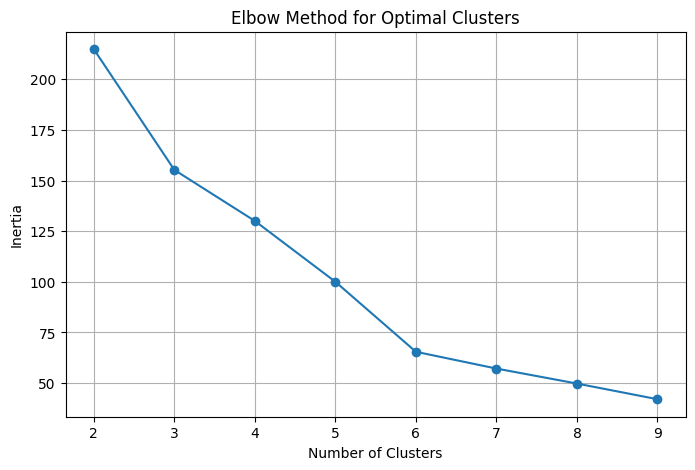

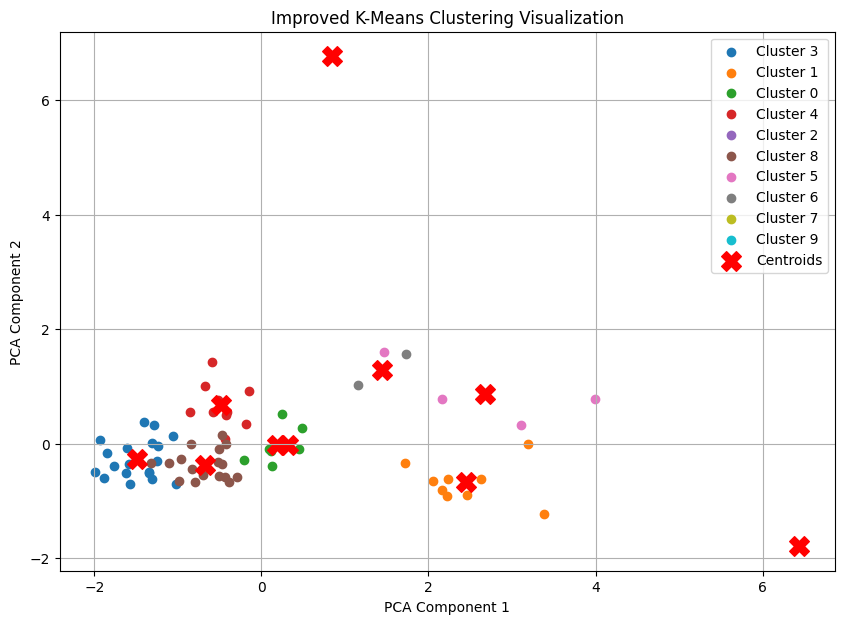

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

clustering_features = ["MessageRatio",	"MediaRatio",	"QuestionRatio",	"AvgMessageLength",	"ParticipationScore"]

# NaN 값 처리 (평균값으로 대체)
final_data[clustering_features] = final_data[clustering_features].fillna(0)

# 데이터 정규화
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_data[clustering_features])

# 적절한 클러스터 개수 탐색 (Elbow Method)
inertia = []
max_clusters = min(10, len(final_data))  # 최대 클러스터 수는 데이터 포인트 개수를 넘지 않도록 설정
for k in range(2, max_clusters):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, max_clusters), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

# K-Means 클러스터링 수행 (적절한 클러스터 수 선택)
optimal_k = min(10, len(final_data))  # 클러스터 수는 데이터 포인트 개수보다 작거나 같아야 함
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
final_data["Cluster"] = clusters

# PCA를 사용하여 2차원으로 차원 축소
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_data)
final_data["PCA1"] = reduced_features[:, 0]
final_data["PCA2"] = reduced_features[:, 1]

# 클러스터링 시각화
plt.figure(figsize=(10, 7))
for cluster in final_data["Cluster"].unique():
    cluster_data = final_data[final_data["Cluster"] == cluster]
    plt.scatter(cluster_data["PCA1"], cluster_data["PCA2"], label=f"Cluster {cluster}")

# 클러스터 중심 표시
cluster_centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=200, c='red', marker='X', label="Centroids")

plt.title("Improved K-Means Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid()
plt.show()


In [8]:
final_data.shape

(72, 8)

# Agglomerative 클러스터링

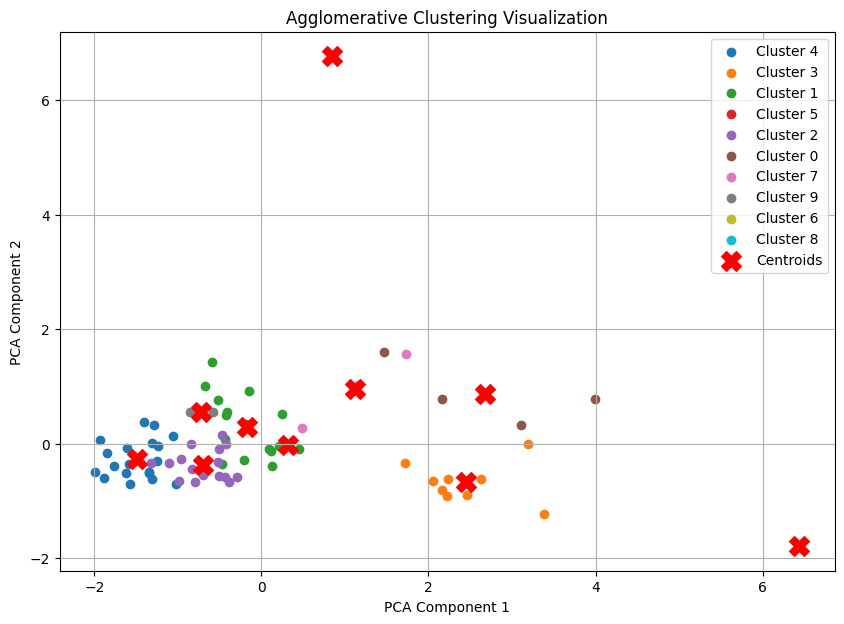

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

clustering_features = ["MessageRatio", "MediaRatio", "QuestionRatio", "AvgMessageLength", "ParticipationScore"]

# NaN 값 처리 (0으로 대체)
final_data[clustering_features] = final_data[clustering_features].fillna(0)

# 데이터 정규화
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_data[clustering_features])

# Agglomerative Clustering 수행
n_clusters = 10  # 클러스터 개수 설정
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
clusters = agg_clustering.fit_predict(scaled_data)
final_data["Cluster"] = clusters

# PCA를 사용하여 2차원으로 차원 축소
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_data)
final_data["PCA1"] = reduced_features[:, 0]
final_data["PCA2"] = reduced_features[:, 1]

# 클러스터 중심 계산
# Agglomerative Clustering은 클러스터 중심을 직접 제공하지 않으므로 클러스터 평균을 계산
cluster_centers = []
for cluster in range(n_clusters):
    cluster_points = reduced_features[clusters == cluster]
    cluster_centers.append(cluster_points.mean(axis=0))
cluster_centers = np.array(cluster_centers)

# 각 데이터에 Centroid 추가
final_data["Centroid_PCA1"] = final_data["Cluster"].apply(lambda x: cluster_centers[x, 0])
final_data["Centroid_PCA2"] = final_data["Cluster"].apply(lambda x: cluster_centers[x, 1])

# 클러스터링 시각화
plt.figure(figsize=(10, 7))
for cluster in final_data["Cluster"].unique():
    cluster_data = final_data[final_data["Cluster"] == cluster]
    plt.scatter(cluster_data["PCA1"], cluster_data["PCA2"], label=f"Cluster {cluster}")

# 클러스터 중심 표시
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=200, c='red', marker='X', label="Centroids")

plt.title("Agglomerative Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid()
plt.show()


# GMM 클러스터링

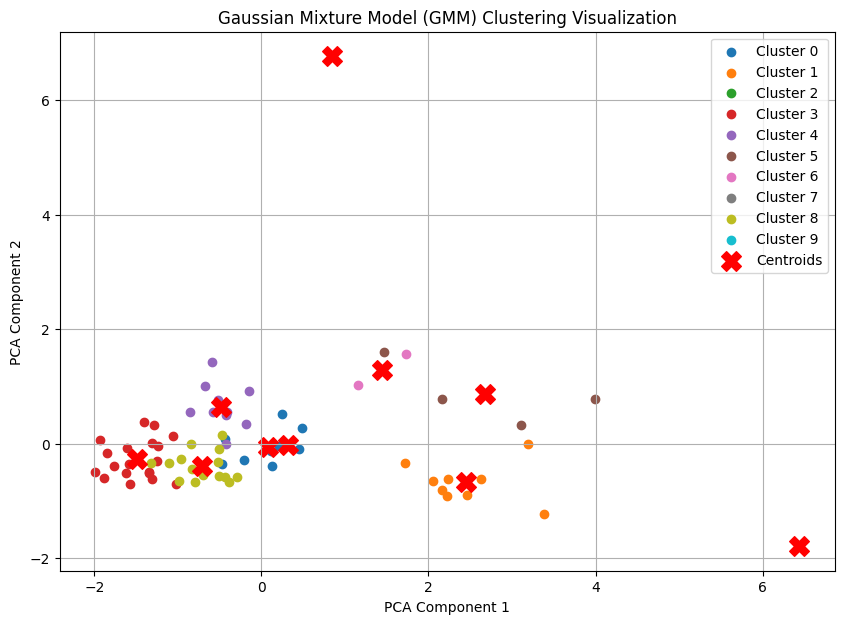

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

clustering_features = ["MessageRatio",	"MediaRatio",	"QuestionRatio",	"AvgMessageLength",	"ParticipationScore"]

# NaN 값 처리 (0으로 대체)
final_data[clustering_features] = final_data[clustering_features].fillna(0)

# 데이터 정규화
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_data[clustering_features])

# Gaussian Mixture Model 클러스터링 수행
n_clusters = 10  # 클러스터 개수 설정
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
clusters = gmm.fit_predict(scaled_data)
final_data["Cluster"] = clusters

# PCA를 사용하여 2차원으로 차원 축소
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_data)
final_data["PCA1"] = reduced_features[:, 0]
final_data["PCA2"] = reduced_features[:, 1]

# 클러스터링 시각화
plt.figure(figsize=(10, 7))
for cluster in set(clusters):
    cluster_data = final_data[final_data["Cluster"] == cluster]
    plt.scatter(cluster_data["PCA1"], cluster_data["PCA2"], label=f"Cluster {cluster}")

# 클러스터 중심 표시
cluster_centers = pca.transform(gmm.means_)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=200, c='red', marker='X', label="Centroids")

plt.title("Gaussian Mixture Model (GMM) Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid()
plt.show()


# 아래는 데이터의 분산을 낮춘 후(데이터 이상치 제거 후) 진행한거

# Train 데이터 클러스터링 진행

# K-means, Agglomerative, GMM 클러스터링 순

In [ ]:
train = pd.read_csv('drive/MyDrive/AI_X<중급>/기말고사/train.csv')

In [ ]:
train.shape

(509, 8)

In [ ]:
train.head(10)
train.drop(['User','StartDate','EndDate'],axis = 1 )

,MessageRatio,MediaRatio,QuestionRatio,AvgMessageLength,ParticipationScore
0,0.226190,0.333333,0.200000,24.250000,3.333333
1,0.166667,0.000000,0.066667,5.000000,3.333333
2,0.226190,0.000000,0.200000,5.750000,4.333333
3,0.642857,0.666667,0.533333,53.277778,6.000000
4,0.216667,0.200000,0.178571,43.625000,3.333333
...,...,...,...,...,...
504,0.256050,0.100000,0.197917,17.944444,7.666667
505,0.500000,0.000000,0.285714,11.000000,10.500000
506,0.333333,0.000000,0.142857,8.000000,10.500000
507,0.291667,0.000000,0.285714,20.000000,12.000000


# 엘보우 기법 설명

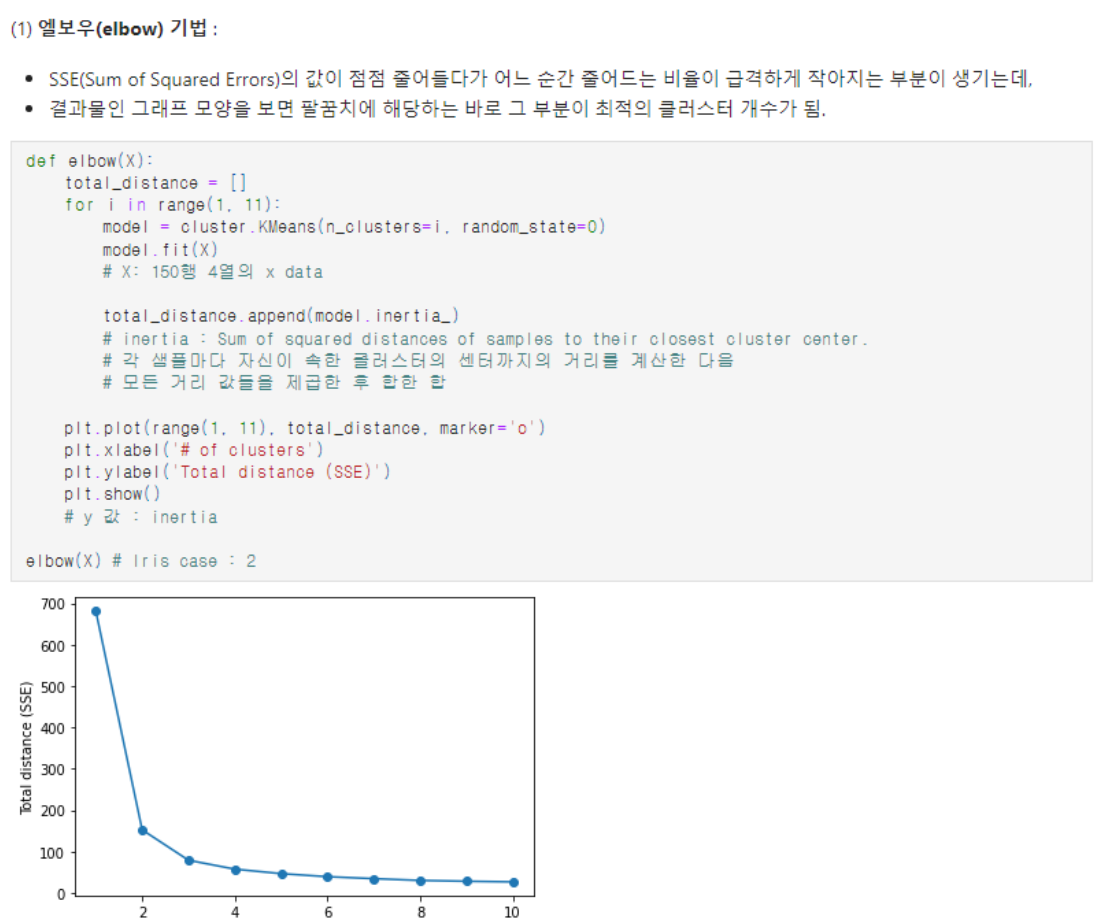

# 실루엣 기법 설명

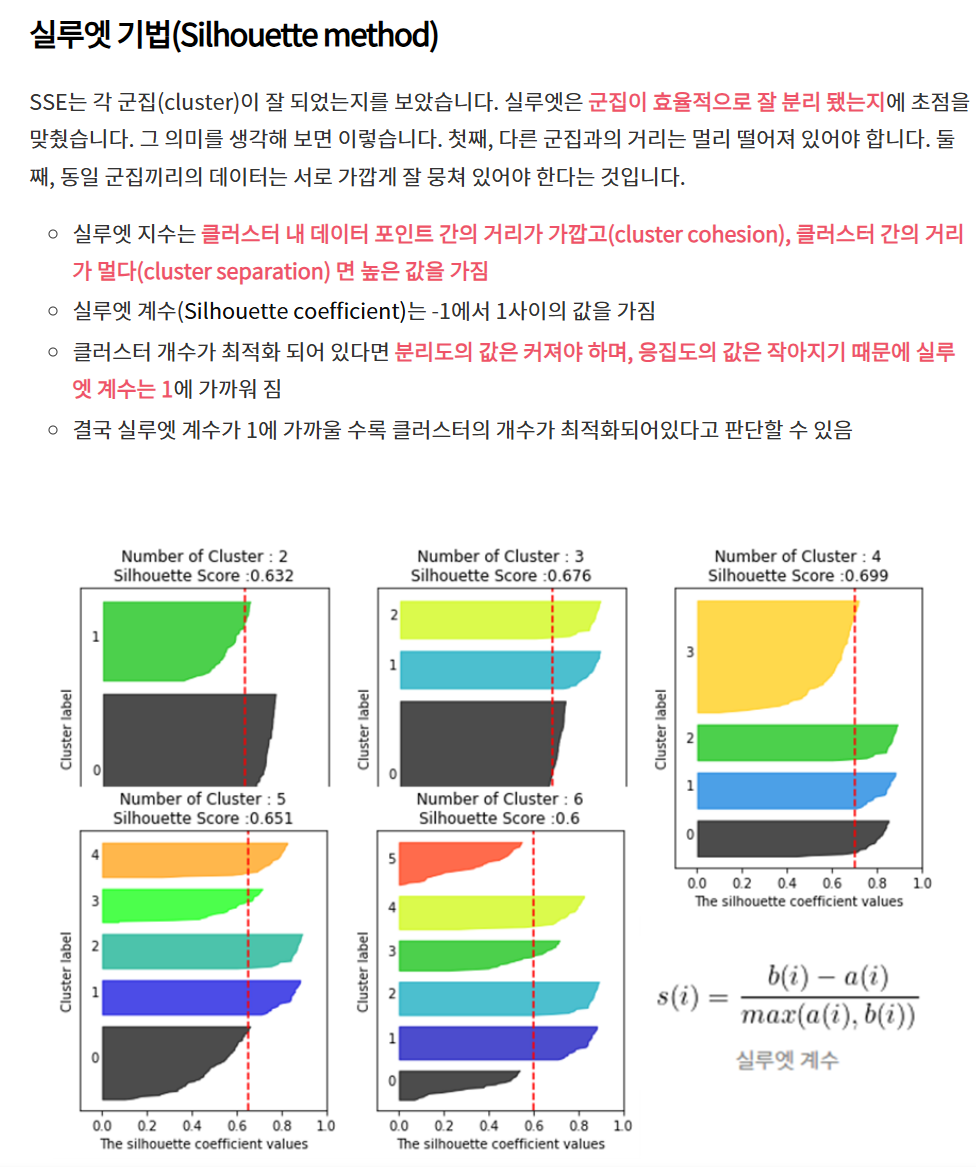

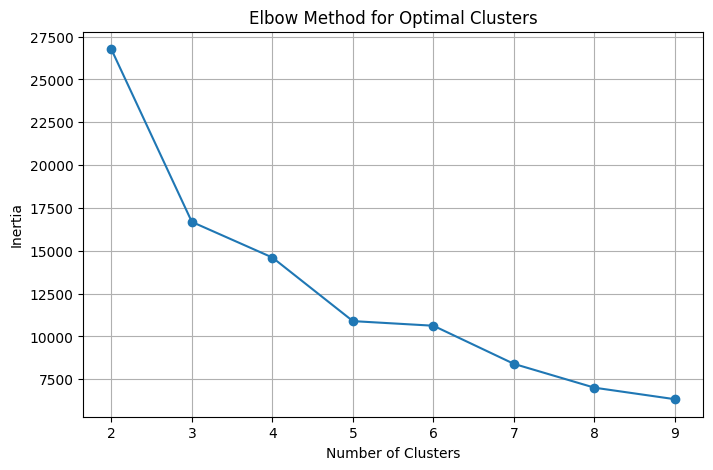

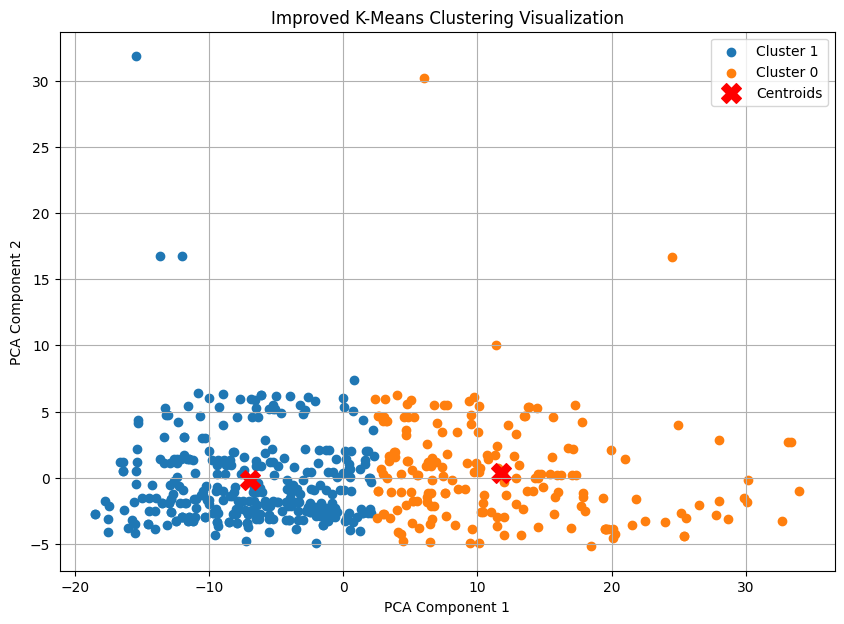

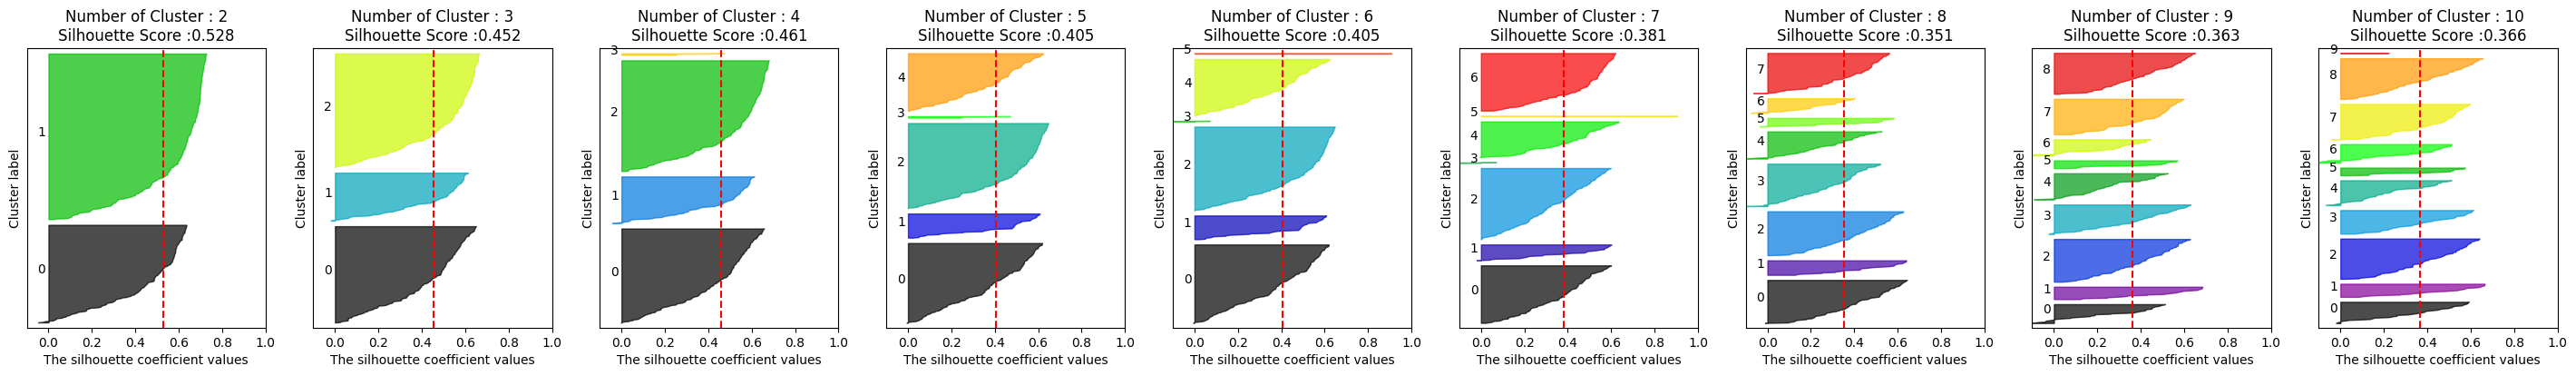

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

clustering_features = ["MessageRatio", "MediaRatio", "QuestionRatio", "AvgMessageLength", "ParticipationScore"]

# 데이터에서 클러스터링에 사용할 특징 추출
train_data = train[clustering_features].values

# 적절한 클러스터 개수 탐색 (Elbow Method)
inertia = []
max_clusters = min(10, len(train))  # 최대 클러스터 수는 데이터 포인트 개수를 넘지 않도록 설정
for k in range(2, max_clusters):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, max_clusters), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

# K-Means 클러스터링 수행 (적절한 클러스터 수 선택)
optimal_k = 2 # Silhouette 계수에 기반해 클러스터 수 선택 가능
kmeans = KMeans(n_clusters=optimal_k, random_state=42, max_iter=500)
clusters = kmeans.fit_predict(train_data)
train["Cluster"] = clusters

# 클러스터 중심 좌표 계산 (원래 feature 공간에서)
original_cluster_centers = kmeans.cluster_centers_
train[["Centroid_MessageRatio", "Centroid_MediaRatio", "Centroid_QuestionRatio",
       "Centroid_AvgMessageLength", "Centroid_ParticipationScore"]] = train["Cluster"].apply(
    lambda x: original_cluster_centers[x]
).tolist()

# PCA를 사용하여 2차원으로 차원 축소
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(train_data)
train["PCA1"] = reduced_features[:, 0]
train["PCA2"] = reduced_features[:, 1]

# 클러스터링 시각화
plt.figure(figsize=(10, 7))
for cluster in train["Cluster"].unique():
    cluster_data = train[train["Cluster"] == cluster]
    plt.scatter(cluster_data["PCA1"], cluster_data["PCA2"], label=f"Cluster {cluster}")

# 차원 축소 후 클러스터 중심 계산 및 표시
pca_centers = pca.transform(original_cluster_centers)
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], s=200, c='red', marker='X', label="Centroids")

plt.title("Improved K-Means Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid()
plt.show()

# Silhouette Score 시각화 함수
def visualize_silhouette(cluster_lists, X_features):
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols)

    for ind, n_cluster in enumerate(cluster_lists):
        clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=42)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels == i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

# Silhouette 시각화 호출
visualize_silhouette([2, 3, 4, 5, 6, 7, 8, 9, 10], train_data)

In [ ]:
train.head(10)

,User,MessageRatio,MediaRatio,QuestionRatio,AvgMessageLength,ParticipationScore,StartDate,EndDate,Cluster,Centroid_MessageRatio,Centroid_MediaRatio,Centroid_QuestionRatio,Centroid_AvgMessageLength,Centroid_ParticipationScore,PCA1,PCA2
0,김명건,0.226190,0.333333,0.200000,24.250000,3.333333,2023-05-02,2023-05-10,0,0.274109,0.201619,0.226368,25.934483,6.876773,0.746695,-3.312555
1,박세은,0.166667,0.000000,0.066667,5.000000,3.333333,2023-05-02,2023-05-10,2,0.222993,0.124580,0.178779,13.870443,5.924174,-18.496581,-2.745275
2,자시 1조 솔,0.226190,0.000000,0.200000,5.750000,4.333333,2023-05-02,2023-05-10,2,0.222993,0.124580,0.178779,13.870443,5.924174,-17.716901,-1.766238
3,황유미,0.642857,0.666667,0.533333,53.277778,6.000000,2023-05-02,2023-05-10,1,0.280705,0.214759,0.215999,41.086371,6.761404,29.843582,-1.500150
4,김명건,0.216667,0.200000,0.178571,43.625000,3.333333,2023-05-15,2023-05-17,1,0.280705,0.214759,0.215999,41.086371,6.761404,20.112139,-3.888725
5,박세은,0.284127,0.500000,0.321429,43.222222,3.333333,2023-05-15,2023-05-17,1,0.280705,0.214759,0.215999,41.086371,6.761404,19.711473,-3.872818
6,자시 1조 솔,0.147619,0.100000,0.142857,34.500000,4.333333,2023-05-15,2023-05-17,1,0.280705,0.214759,0.215999,41.086371,6.761404,11.020164,-2.619980
7,황유미,0.423810,0.200000,0.357143,39.416667,6.000000,2023-05-15,2023-05-17,1,0.280705,0.214759,0.215999,41.086371,6.761404,15.985575,-1.095252
8,김명건,0.232143,0.000000,0.148148,17.000000,3.333333,2023-05-22,2023-05-26,2,0.222993,0.124580,0.178779,13.870443,5.924174,-6.501722,-3.100078
9,박세은,0.384921,0.000000,0.296296,23.666667,3.333333,2023-05-22,2023-05-26,0,0.274109,0.201619,0.226368,25.934483,6.876773,0.162594,-3.295274


In [ ]:
train.nunique()

,0
User,54
MessageRatio,412
MediaRatio,58
QuestionRatio,300
AvgMessageLength,397
ParticipationScore,41
StartDate,91
EndDate,90
Cluster,4
Centroid_MessageRatio,4


In [ ]:
train.drop(['StartDate', 'EndDate','PCA1','PCA2'], axis = 1)

,User,MessageRatio,MediaRatio,QuestionRatio,AvgMessageLength,ParticipationScore,Cluster,Centroid_MessageRatio,Centroid_MediaRatio,Centroid_QuestionRatio,Centroid_AvgMessageLength,Centroid_ParticipationScore
0,김명건,0.226190,0.333333,0.200000,24.250000,3.333333,0,0.274109,0.201619,0.226368,25.934483,6.876773
1,박세은,0.166667,0.000000,0.066667,5.000000,3.333333,2,0.222993,0.124580,0.178779,13.870443,5.924174
2,자시 1조 솔,0.226190,0.000000,0.200000,5.750000,4.333333,2,0.222993,0.124580,0.178779,13.870443,5.924174
3,황유미,0.642857,0.666667,0.533333,53.277778,6.000000,1,0.280705,0.214759,0.215999,41.086371,6.761404
4,김명건,0.216667,0.200000,0.178571,43.625000,3.333333,1,0.280705,0.214759,0.215999,41.086371,6.761404
...,...,...,...,...,...,...,...,...,...,...,...,...
504,주연,0.256050,0.100000,0.197917,17.944444,7.666667,2,0.222993,0.124580,0.178779,13.870443,5.924174
505,맹의현,0.500000,0.000000,0.285714,11.000000,10.500000,2,0.222993,0.124580,0.178779,13.870443,5.924174
506,심현지,0.333333,0.000000,0.142857,8.000000,10.500000,2,0.222993,0.124580,0.178779,13.870443,5.924174
507,임준수 AI,0.291667,0.000000,0.285714,20.000000,12.000000,0,0.274109,0.201619,0.226368,25.934483,6.876773


# 각 Feature에 대한 Centroid 값 더하여 클러스터별로 비교할 Centroid_total 값 계산

In [ ]:
# Centroid_Total을 가중치를 적용하여 계산
train['Weighted_total'] = (
    train['Centroid_MessageRatio'] +
    2 * train['Centroid_MediaRatio'] +  # 가중치 2 적용
    train['Centroid_QuestionRatio'] +
    0.5 * train['Centroid_AvgMessageLength'] +
    train['Centroid_ParticipationScore']
)

# 클러스터별로 하나의 Centroid 정보 추출
weighted_centroid_totals = train.groupby('Cluster').first()
# 클러스터별 Weighted_total 값 확인
print(weighted_centroid_totals[['Centroid_MessageRatio', 'Centroid_MediaRatio',
                             'Centroid_QuestionRatio', 'Centroid_AvgMessageLength',
                             'Centroid_ParticipationScore', 'Weighted_total']])

         Centroid_MessageRatio  Centroid_MediaRatio  Centroid_QuestionRatio  \
Cluster                                                                       
0                     0.274109             0.201619                0.226368   
1                     0.280705             0.214759                0.215999   
2                     0.222993             0.124580                0.178779   
3                     0.404762             0.250000                0.404762   

         Centroid_AvgMessageLength  Centroid_ParticipationScore  \
Cluster                                                           
0                        25.934483                     6.876773   
1                        41.086371                     6.761404   
2                        13.870443                     5.924174   
3                        13.909722                    30.250000   

         Weighted_total  
Cluster                  
0             20.747729  
1             28.230812  
2             13.5

In [ ]:
# 클러스터별 Centroid_total 값 내림차순 정렬
sorted_centroid_totals = weighted_centroid_totals.sort_values(by='Weighted_total', ascending=False)

# 결과 확인
sorted_centroid_totals[['Weighted_total']].head()

,Weighted_total
Cluster,
3,38.514385
1,28.230812
0,20.747729
2,13.510329


# 3번 클러스터가 매우높음(4점)
# 1번 클러스터가 높음(3점)
# 0번 클러스터가 낮음(2점)
# 2번 클러스터가 매우낮음(1점)

In [ ]:
# 클러스터별로 하나의 Centroid 정보 추출
weighted_centroid_totals = train.groupby('Cluster').first()

# 클러스터별 Centroid 정보와 Weighted_total 값을 포함한 데이터프레임 생성
centroid_data = weighted_centroid_totals[[
    'Centroid_MessageRatio',
    'Centroid_MediaRatio',
    'Centroid_QuestionRatio',
    'Centroid_AvgMessageLength',
    'Centroid_ParticipationScore',
    'Weighted_total'
]].reset_index()  # Cluster 값을 포함하기 위해 reset_index 사용

# 결과를 CSV 파일로 저장
centroid_data.to_csv("drive/MyDrive/AI_X<중급>/기말고사/Centroid.csv", index=False, encoding="utf-8-sig")

In [ ]:
test1 = pd.read_csv('drive/MyDrive/AI_X<중급>/기말고사/munsik_4_3day_group1.csv')

In [ ]:
train = pd.read_csv('drive/MyDrive/AI_X<중급>/기말고사/train.csv')

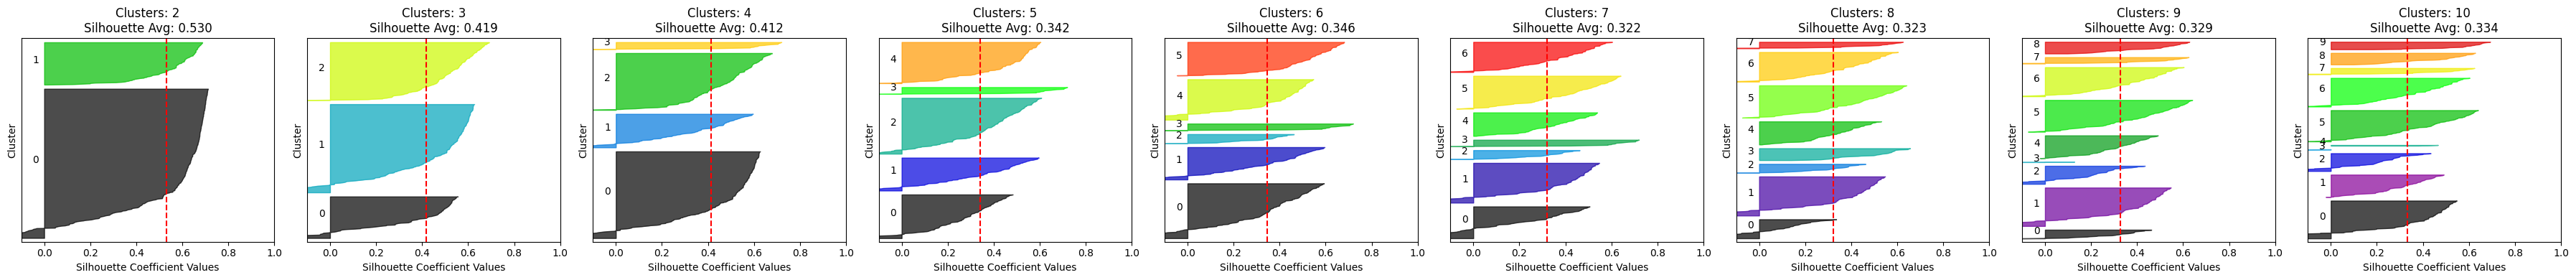

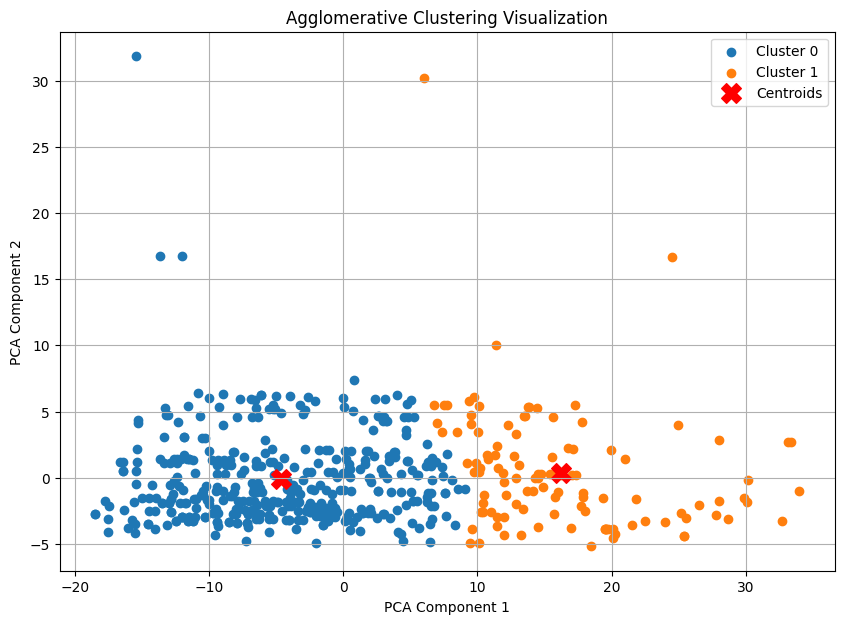

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# 데이터
clustering_features = ["MessageRatio", "MediaRatio", "QuestionRatio", "AvgMessageLength", "ParticipationScore"]
train[clustering_features] = train[clustering_features].fillna(0)

# Silhouette 시각화 함수
def visualize_silhouette(cluster_lists, X_features):
    fig, axs = plt.subplots(figsize=(4 * len(cluster_lists), 4), nrows=1, ncols=len(cluster_lists))

    for ind, n_cluster in enumerate(cluster_lists):
        agg_clustering = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward')
        cluster_labels = agg_clustering.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title(f'Clusters: {n_cluster}\nSilhouette Avg: {sil_avg:.3f}')
        axs[ind].set_xlabel("Silhouette Coefficient Values")
        axs[ind].set_ylabel("Cluster")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels == i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values,
                                   facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

    plt.tight_layout()
    plt.show()

# Silhouette Score 계산 및 시각화
visualize_silhouette([2, 3, 4, 5, 6, 7, 8, 9, 10], train[clustering_features])

# Agglomerative Clustering 수행
n_clusters = 2
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
clusters = agg_clustering.fit_predict(train[clustering_features])
train["Cluster"] = clusters

# PCA를 사용하여 2차원으로 차원 축소
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(train[clustering_features])
train["PCA1"] = reduced_features[:, 0]
train["PCA2"] = reduced_features[:, 1]

# 클러스터 중심 계산 (평균값)
cluster_centers = []
for cluster in range(n_clusters):
    cluster_points = reduced_features[clusters == cluster]
    cluster_centers.append(cluster_points.mean(axis=0))
cluster_centers = np.array(cluster_centers)

# 각 데이터에 Centroid 추가
def get_centroid_coordinates(cluster_label):
    return cluster_centers[cluster_label]

train["Centroid_PCA1"], train["Centroid_PCA2"] = zip(*train["Cluster"].apply(get_centroid_coordinates))

# 클러스터링 시각화
plt.figure(figsize=(10, 7))
for cluster in train["Cluster"].unique():
    cluster_data = train[train["Cluster"] == cluster]
    plt.scatter(cluster_data["PCA1"], cluster_data["PCA2"], label=f"Cluster {cluster}")

# 클러스터 중심 표시
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=200, c='red', marker='X', label="Centroids")
plt.title("Agglomerative Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid()
plt.show()


In [ ]:
train = pd.read_csv('drive/MyDrive/AI_X<중급>/기말고사/train.csv')

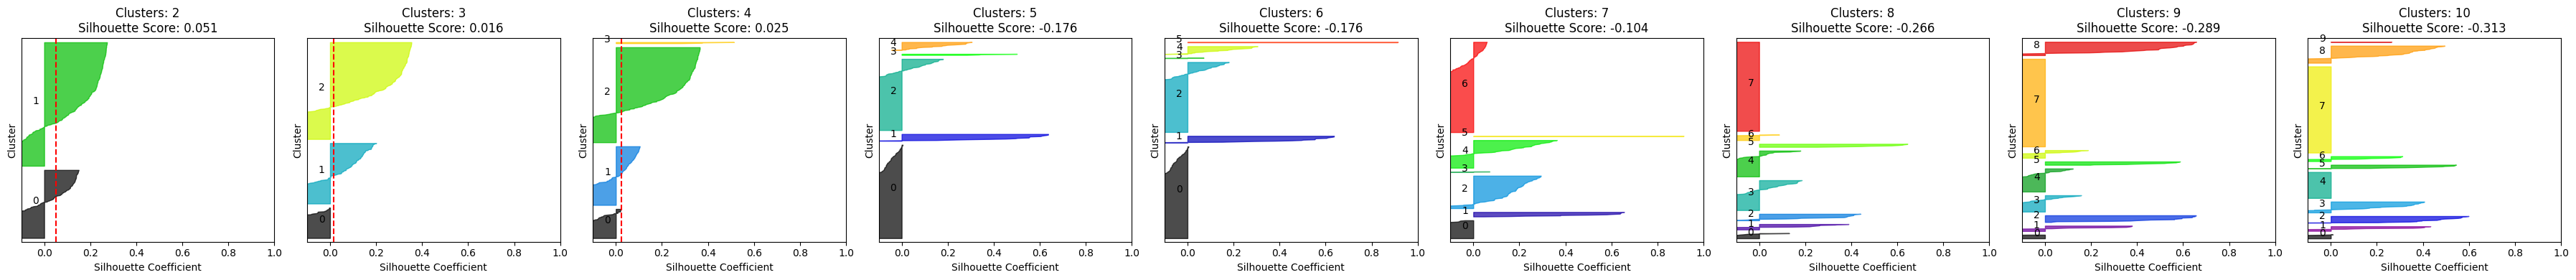

Optimal number of clusters based on analysis: 2


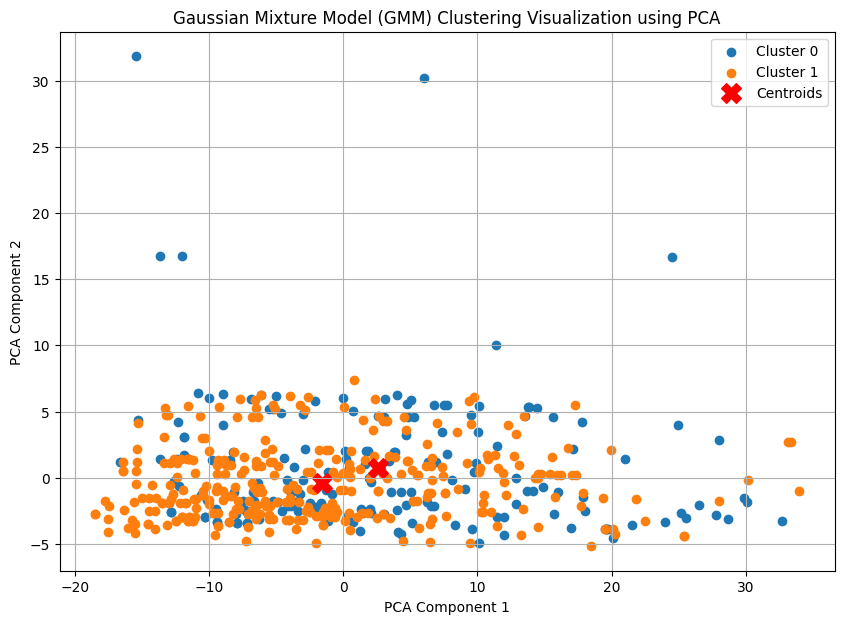

In [22]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

clustering_features = ["MessageRatio", "MediaRatio", "QuestionRatio", "AvgMessageLength", "ParticipationScore"]

# NaN 값 처리 (0으로 대체)
train[clustering_features] = train[clustering_features].fillna(0)

def visualize_silhouette(cluster_lists, X_features):
    from sklearn.metrics import silhouette_samples, silhouette_score
    import matplotlib.cm as cm

    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols)

    for ind, n_cluster in enumerate(cluster_lists):
        gmm = GaussianMixture(n_components=n_cluster, random_state=42)
        cluster_labels = gmm.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title(f'Clusters: {n_cluster}\nSilhouette Score: {sil_avg:.3f}')
        axs[ind].set_xlabel("Silhouette Coefficient")
        axs[ind].set_ylabel("Cluster")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels == i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                   facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

    plt.tight_layout()
    plt.show()

# 클러스터 개수에 따른 Silhouette 시각화
visualize_silhouette([2, 3, 4, 5, 6, 7, 8, 9, 10], train[clustering_features].values)

# Gaussian Mixture Model 클러스터링 수행
optimal_n_clusters = 2  # 적절한 클러스터 수 선택
print(f"Optimal number of clusters based on analysis: {optimal_n_clusters}")

gmm = GaussianMixture(n_components=optimal_n_clusters, random_state=42)
clusters = gmm.fit_predict(train[clustering_features].values)
train["Cluster"] = clusters

# PCA를 사용하여 2차원으로 차원 축소
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(train[clustering_features].values)
train["PCA1"] = reduced_features[:, 0]
train["PCA2"] = reduced_features[:, 1]

# 클러스터링 시각화
plt.figure(figsize=(10, 7))
for cluster in set(clusters):
    cluster_data = train[train["Cluster"] == cluster]
    plt.scatter(cluster_data["PCA1"], cluster_data["PCA2"], label=f"Cluster {cluster}")

# 클러스터 중심 표시
cluster_centers = pca.transform(gmm.means_)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=200, c='red', marker='X', label="Centroids")

plt.title("Gaussian Mixture Model (GMM) Clustering Visualization using PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid()
plt.show()
